In [1]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from torch import nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch

In [2]:
from soft_mh import Model1, Model2, Model3, train_model1, train_model2, train_model3
from HFocalLoss import FocalLoss
from weights import compute_class_frequencies, compute_alpha
from augmentation import augment_image

In [3]:
X = np.load("data/3x3_data_nparray.npy")
y_leaf = np.load("data/3x3_leafs.npy")
y_genus = np.load("data/3x3_genus.npy")
y_species = np.load("data/3x3_labels_nparray.npy")

In [4]:
X_tensor = torch.from_numpy(X)
y_l_tensor = torch.from_numpy(y_leaf).long()
y_l_tensor = torch.argmax(y_l_tensor, dim=1)

y_g_tensor = torch.from_numpy(y_genus).long()
y_g_tensor = torch.argmax(y_g_tensor, dim=1)

y_s_tensor = torch.from_numpy(y_species).long()
y_s_tensor = torch.argmax(y_s_tensor, dim=1)

In [5]:
class_counts = torch.bincount(y_s_tensor)
minority_classes = torch.where(class_counts < 1000)[0]

minority_indices = torch.cat([torch.where(y_s_tensor == cls)[0] for cls in minority_classes])

minority_data = X_tensor[minority_indices]
minority_labels_l = y_l_tensor[minority_indices]
minority_labels_g = y_g_tensor[minority_indices]
minority_labels_s = y_s_tensor[minority_indices]

In [6]:
augmented_data = []
augmented_labels_l = []
augmented_labels_g = []
augmented_labels_s = []

for i, image in enumerate(minority_data):
    img1, img2, img3, img4, img5 = augment_image(image.numpy())  # Convert tensor to numpy for processing
    
    augmented_data.extend([img1, img2, img3, img4, img5])
    
    augmented_labels_l.extend([minority_labels_l[i].item()] * 5)# Append the same label
    augmented_labels_g.extend([minority_labels_g[i].item()] * 5)
    augmented_labels_s.extend([minority_labels_s[i].item()] * 5)

# Convert back to tensors
augmented_data = torch.tensor(augmented_data, dtype=torch.float32)
augmented_labels_l = torch.tensor(augmented_labels_l, dtype=torch.long)
augmented_labels_g = torch.tensor(augmented_labels_g, dtype=torch.long)
augmented_labels_s = torch.tensor(augmented_labels_s, dtype=torch.long)

# Combine augmented data with original dataset
X_augmented = torch.cat((X_tensor, augmented_data), dim=0).permute(0,3,1,2)

y_augmented_l = torch.cat((y_l_tensor, augmented_labels_l), dim=0)
y_augmented_g = torch.cat((y_g_tensor, augmented_labels_g), dim=0)
y_augmented_s = torch.cat((y_s_tensor, augmented_labels_s), dim=0)

y_augmented_l = torch.nn.functional.one_hot(y_augmented_l, num_classes=2).float()
y_augmented_g = torch.nn.functional.one_hot(y_augmented_g, num_classes=9).float()
y_augmented_s = torch.nn.functional.one_hot(y_augmented_s, num_classes=19).float()

C:\Users\matte\AppData\Local\Temp\ipykernel_14328\2002076170.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  augmented_data = torch.tensor(augmented_data, dtype=torch.float32)


In [7]:
genus_frequencies = compute_class_frequencies(y_augmented_g.numpy())

# Example: Compute frequencies for level 3 labels (assuming level_3_labels is a list of all labels)
species_frequencies = compute_class_frequencies(y_augmented_s.numpy())
print(y_augmented_g)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [8]:
num_classes_genus = y_augmented_g.shape[1]  

num_classes_species = y_augmented_s.numpy().shape[1]  
num_samples = y_augmented_s.shape[0]

In [9]:
alphas_genus = compute_alpha(genus_frequencies, num_samples, num_classes_genus)

alphas_species = compute_alpha(species_frequencies, num_samples, num_classes_species)

In [10]:
alpha_tensor_genus = torch.tensor(list(alphas_genus.values()), dtype=torch.float32)
alpha_tensor_species = torch.tensor(list(alphas_species.values()), dtype=torch.float32)

alpha_max = 10  # Maximum allowed alpha
alpha_tensor_genus = torch.clamp(alpha_tensor_genus, max=alpha_max)
alpha_tensor_species = torch.clamp(alpha_tensor_species, max=alpha_max)

In [11]:
model1 = Model1()

In [12]:
y_augmented_l = torch.argmax(y_augmented_l, dim=1)

dataset1 = TensorDataset(X_augmented, y_augmented_l)

dataloader1 = DataLoader(dataset1, batch_size=32, shuffle=True)

In [13]:
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

In [14]:
model1 = train_model1(model1, dataloader1, criterion1, optimizer1)

Epoch 1: Loss = 0.3253, Acc = 0.8637
Epoch 2: Loss = 0.2680, Acc = 0.8937
Epoch 3: Loss = 0.2631, Acc = 0.8978
Epoch 4: Loss = 0.2588, Acc = 0.9005
Epoch 5: Loss = 0.2572, Acc = 0.9002
Epoch 6: Loss = 0.2559, Acc = 0.9004
Epoch 7: Loss = 0.2542, Acc = 0.9000
Epoch 8: Loss = 0.2531, Acc = 0.9002
Epoch 9: Loss = 0.2501, Acc = 0.9018
Epoch 10: Loss = 0.2505, Acc = 0.9011


In [15]:
model2 = Model2(9)

In [16]:
y_augmented_g = torch.argmax(y_augmented_g, dim=1)

dataset2 = TensorDataset(X_augmented, y_augmented_l, y_augmented_g)

dataloader2 = DataLoader(dataset2, batch_size=32, shuffle=True)

In [17]:
criterion2 = FocalLoss(alpha=alpha_tensor_genus, gamma=2.0)
#criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [18]:
model2 = train_model2(model1, model2, dataloader2, criterion2, optimizer2, num_epochs=30)

Epoch 1: Loss = 10.6616, Acc = 0.3865
Epoch 2: Loss = 8.9272, Acc = 0.4810
Epoch 3: Loss = 8.5267, Acc = 0.5039
Epoch 4: Loss = 8.1964, Acc = 0.5242
Epoch 5: Loss = 7.9722, Acc = 0.5373
Epoch 6: Loss = 7.7796, Acc = 0.5479
Epoch 7: Loss = 7.6138, Acc = 0.5545
Epoch 8: Loss = 7.4464, Acc = 0.5609
Epoch 9: Loss = 7.2869, Acc = 0.5698
Epoch 10: Loss = 7.1193, Acc = 0.5787
Epoch 11: Loss = 6.9459, Acc = 0.5880
Epoch 12: Loss = 6.8123, Acc = 0.5950
Epoch 13: Loss = 6.6855, Acc = 0.6021
Epoch 14: Loss = 6.5966, Acc = 0.6069
Epoch 15: Loss = 6.4954, Acc = 0.6123
Epoch 16: Loss = 6.4139, Acc = 0.6164
Epoch 17: Loss = 6.3379, Acc = 0.6193
Epoch 18: Loss = 6.2954, Acc = 0.6229
Epoch 19: Loss = 6.2240, Acc = 0.6261
Epoch 20: Loss = 6.1748, Acc = 0.6284
Epoch 21: Loss = 6.1157, Acc = 0.6294
Epoch 22: Loss = 6.0738, Acc = 0.6353
Epoch 23: Loss = 6.0157, Acc = 0.6381
Epoch 24: Loss = 5.9790, Acc = 0.6397
Epoch 25: Loss = 5.9895, Acc = 0.6392
Epoch 26: Loss = 5.9003, Acc = 0.6432
Epoch 27: Loss = 5.9

In [19]:
model3 = Model3()

In [20]:
y_augmented_s = torch.argmax(y_augmented_s, dim=1)

dataset3 = TensorDataset(X_augmented, y_augmented_l, y_augmented_g, y_augmented_s)

dataloader3 = DataLoader(dataset3, batch_size=32, shuffle=True)

In [21]:
criterion3 = FocalLoss(alpha=alpha_tensor_species, gamma=2.0)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

In [22]:
model3 = train_model3(model1, model2, model3, dataloader3, criterion3, optimizer3, num_epochs=30)

Epoch 1: Loss = 14.1545, Acc = 0.3907
Epoch 2: Loss = 11.4137, Acc = 0.4855
Epoch 3: Loss = 10.3772, Acc = 0.5264
Epoch 4: Loss = 9.6965, Acc = 0.5539
Epoch 5: Loss = 9.0966, Acc = 0.5756
Epoch 6: Loss = 8.5738, Acc = 0.5941
Epoch 7: Loss = 8.2516, Acc = 0.6058
Epoch 8: Loss = 7.9308, Acc = 0.6170
Epoch 9: Loss = 7.6622, Acc = 0.6277
Epoch 10: Loss = 7.3729, Acc = 0.6343
Epoch 11: Loss = 7.1722, Acc = 0.6407
Epoch 12: Loss = 6.9397, Acc = 0.6481
Epoch 13: Loss = 6.6789, Acc = 0.6577
Epoch 14: Loss = 6.4844, Acc = 0.6625
Epoch 15: Loss = 6.3392, Acc = 0.6697
Epoch 16: Loss = 6.1676, Acc = 0.6731
Epoch 17: Loss = 6.0042, Acc = 0.6788
Epoch 18: Loss = 5.8610, Acc = 0.6857
Epoch 19: Loss = 5.6968, Acc = 0.6891
Epoch 20: Loss = 5.5444, Acc = 0.6944
Epoch 21: Loss = 5.4014, Acc = 0.6998
Epoch 22: Loss = 5.2756, Acc = 0.7045
Epoch 23: Loss = 5.1941, Acc = 0.7074
Epoch 24: Loss = 5.0832, Acc = 0.7104
Epoch 25: Loss = 4.9445, Acc = 0.7157
Epoch 26: Loss = 4.8210, Acc = 0.7194
Epoch 27: Loss = 4

In [23]:
X_test = np.load("test/test_bands.npy")
y_test_leaf = np.load("test/test_leaf_labels.npy")
y_test_genus = np.load("test/test_genus_labels.npy")
y_test_species = np.load("test/test_labels.npy")

In [24]:
X_torch = torch.from_numpy(X_test).permute(0,3,1,2)

leaf_pred = model1(X_torch)

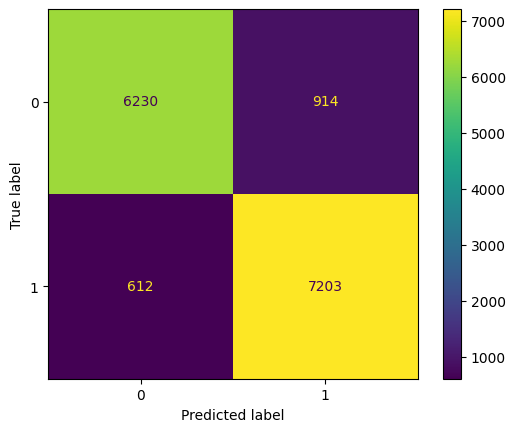

Accuracy binary classification on leaf level:  0.8979878334113243


In [25]:
y_pred_np = leaf_pred.detach().cpu().numpy()
y_pred_labels = np.argmax(y_pred_np, axis=1)

y_test_np = np.argmax(y_test_leaf, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_labels)
plt.show()

acc = accuracy_score(y_test_np, y_pred_labels)
print("Accuracy binary classification on leaf level: ", acc)

In [26]:
genus_pred = model2(X_torch, leaf_pred)

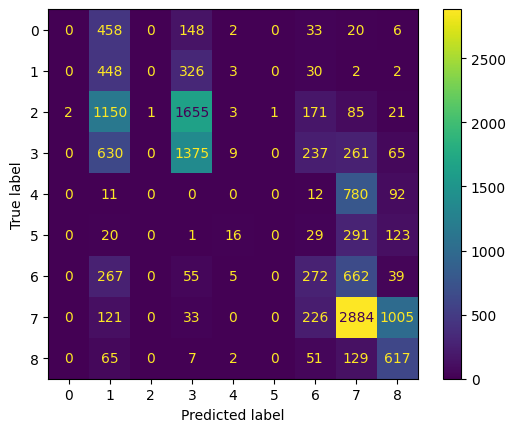

Accuracy on genus level:  0.3741560264723578


In [27]:
y_pred_np = genus_pred.detach().cpu().numpy()
y_pred_labels = np.argmax(y_pred_np, axis=1)

y_test_np = np.argmax(y_test_genus, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_labels)
plt.show()

acc = accuracy_score(y_test_np, y_pred_labels)
print("Accuracy on genus level: ", acc)

In [28]:
model3.eval()

species_pred = model3(X_torch, leaf_pred, genus_pred)

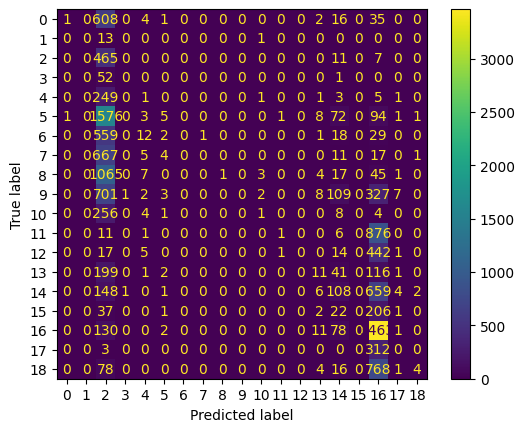

Accuracy on species level:  0.2714753660004011


In [29]:
y_pred_np = species_pred.detach().cpu().numpy()
y_pred_labels = np.argmax(y_pred_np, axis=1)

y_test_np = np.argmax(y_test_species, axis=1)

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_labels)
plt.show()

acc = accuracy_score(y_test_np, y_pred_labels)
print("Accuracy on species level: ", acc)